In [26]:
from Python.core_functions import *

import itertools
import numpy as np

from qiskit import quantum_info as qi
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from scipy.linalg import expm

# 1. Circuit Construction and Noisy Simulation

## 1.1 Draw Sequences, Construct Circuits

In [16]:
# even 10.000 samples didn't seem to be enough for a good reconstruction accuray in the 11 block. So: more samples! 

# parameters
lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
number_qubits = 2
number_samples = 15000

# random sequence generation
crosstalk_sequences = draw_sequences(number_qubits, 'local', lengths, number_samples)

# construct circuits
crosstalk_circuits = construct_circuits(crosstalk_sequences, number_qubits)

# construct PTMs
ptms = get_ptms(crosstalk_sequences)

# optional: save sequences and sparse PTMs

# with open('crosstalk_sequences', 'wb') as fp:
#     pickle.dump(crosstalk_sequences, fp)

# sparse_ptms = array_to_sparse(ptms)
# with open('crosstalk_ptms', 'wb') as fp:
#     pickle.dump(sparse_ptms, fp)

18:51:31
done generating sequences
19:22:23
done constructing circuits


## 1.2 Insert Crosstalk

In [19]:
# define XX and ZZ crosstalk
pauli_x = np.array([[0., 1.], [1., 0.]])
pauli_z = np.array([[1., 0.], [0., -1.]])

eps = 0.4
xx_array = expm(-1j/2 * eps * np.kron(pauli_x, pauli_x))
zz_array = expm(-1j/2 * eps * np.kron(pauli_z, pauli_z))

zz_gate = custom_unitary(crosstalk_circuits[0][0], zz_array, "zz")
xx_gate = custom_unitary(crosstalk_circuits[0][0], xx_array, "xx")


# insert the crosstalk into the circuits
zz_circs = []
xx_circs = []

for length in range(len(crosstalk_circuits)):
    new_circs_zz = []
    new_circs_xx = []

    for rep in range(len(crosstalk_circuits[length])):
        circ_zz = insert_error(crosstalk_circuits[length][rep], zz_gate)
        circ_xx = insert_error(crosstalk_circuits[length][rep], xx_gate)
        
        new_circs_zz.append(circ_zz)
        new_circs_xx.append(circ_xx)

    zz_circs.append(new_circs_zz)
    xx_circs.append(new_circs_xx)

## 1.3 Noisy Simulation

In [27]:
# create noise model
custom_noise = NoiseModel()

p_single = 0.002

custom_noise.add_all_qubit_quantum_error(depolarizing_error(p_single, 1), ['rx', 'ry', 'rz'])

native_gates = ['rx', 'ry', 'rz', 'cx']

noisy_data_zz_crosstalk = noisy_simulation(zz_circs, number_qubits, 1000, number_samples, lengths, noise_model=custom_noise, gateset=native_gates)

with open('noisy_data_zz_crosstalk.npy', 'wb') as f:
    np.save(f, noisy_data_zz_crosstalk)

noisy_data_xx_crosstalk = noisy_simulation(xx_circs, number_qubits, 1000, number_samples, lengths, noise_model=custom_noise, gateset=native_gates)

with open('noisy_data_xx_crosstalk.npy', 'wb') as f:
    np.save(f, noisy_data_xx_crosstalk)

20:38:31
starting probs_zz
01:14:58
done with probs_zz


# 2. Post-processing


The following blocks reconstruct the PTMs from estimated decay rates and plot the reconstruction as well as the crosstalk characterization matrices $\Lambda_{11} - \Lambda_{10} \otimes \Lambda_{01}$.

Note: the actual estimation of decay rates is performed in the Julia notebook "crosstalk_tomography_julia.ipynb". For convenience, the results for ZZ and XX crosstalk are provided in the "data" subfolder.

## 2.1 XX crosstalk

In [28]:
# import the decay rates calculated with the Julia implementation:
xx01 = np.load("data/xx01.npz")
xx10 = np.load("data/xx10.npz")
xx11 = np.load("data/xx11.npz")

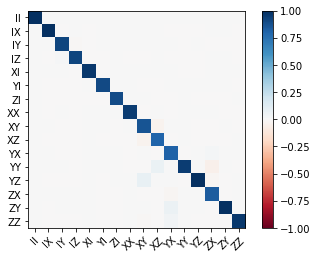

In [148]:
# reconstruct and plot the PTM of the pinched marginal:

two_qubit_cliffords = get_two_qubit_cliffords()
xx_reconstruction = reconstruct_channel(two_qubit_cliffords, xx01, xx10, xx11)

plot_ptm(xx_reconstruction, save=True, filename="crosstalk_tomography_xx_reconstruction.svg")

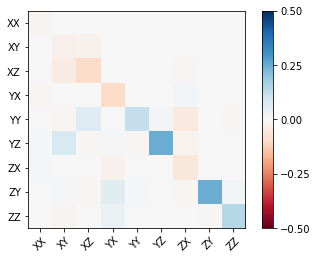

In [153]:
# plot the difference between the 11 block and the 10x01 tensor product:

plot_diff(xx_reconstruction, save=True, filename="crosstalk_tomography_xx_diff.svg")

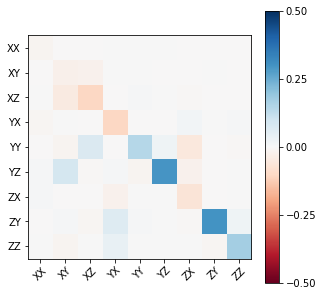

In [123]:
# for comparison: plot the difference between the identity and the product of the 11 subblock with the inverse of the 10x01 tensor product 

xx_sub01, xx_sub10, xx_tensorprod, xx_sub11 = get_ptm_subblocks(xx_reconstruction)

fig, ax = plt.subplots(1, 1, figsize=(5,5))

im = ax.imshow(xx_sub11 @ np.linalg.inv(xx_tensorprod) - np.identity(9), cmap="RdBu", vmin=-0.5, vmax=0.5)
labels = [''.join(x) for x in itertools.product('XYZ', repeat=2)]
cb = plt.colorbar(im, ax=ax, ticks=[-0.5, -0.25, 0, 0.25, 0.5])
ax.set_xticks(range(9))
ax.set_yticks(range(9))
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
plt.savefig("xx_diff.svg")
plt.show()

## 2.2 ZZ crosstalk

In [70]:
# read in decay rates:
zz01 = np.load("data/zz01.npz")
zz10 = np.load("data/zz10.npz")
zz11 = np.load("data/zz11.npz")

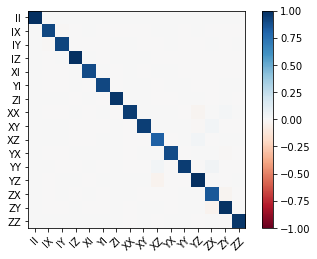

In [146]:
# reconstruct and plot the PTM of the pinched marginal:

zz_reconstruction = reconstruct_channel(two_qubit_cliffords, zz01, zz10, zz11)
plot_ptm(zz_reconstruction, save=True, filename="crosstalk_tomography_zz_reconstruction.svg")

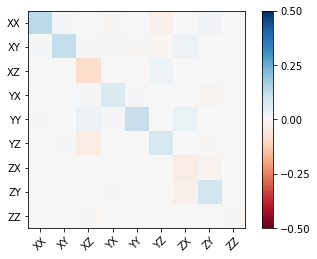

In [152]:
# plot the difference between the 11 block and the 10x01 tensor product:

plot_diff(zz_reconstruction, save=True, filename="crosstalk_tomography_zz_diff.svg")

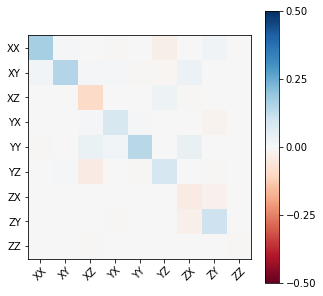

In [119]:
# for comparison: plot the difference between the identity and the product of the 11 subblock with the inverse of the 10x01 tensor product 

zz_sub01, zz_sub10, zz_tensorprod, zz_sub11 = get_ptm_subblocks(zz_reconstruction)

fig, ax = plt.subplots(1, 1, figsize=(5,5))

im = ax.imshow(zz_sub11 @ np.linalg.inv(zz_tensorprod) - np.identity(9), cmap="RdBu", vmin=-0.5, vmax=0.5)
labels = [''.join(x) for x in itertools.product('XYZ', repeat=2)]
cb = plt.colorbar(im, ax=ax, ticks=[-0.5, -0.25, 0, 0.25, 0.5])
ax.set_xticks(range(9))
ax.set_yticks(range(9))
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
plt.savefig("zz_diff.svg")
plt.show()